In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

In [2]:
# Load the image
image_path = "../data/images/ngc2403.png"
image_data = np.dot(plt.imread(image_path)[..., :3], [0.2989, 0.5870, 0.1140])

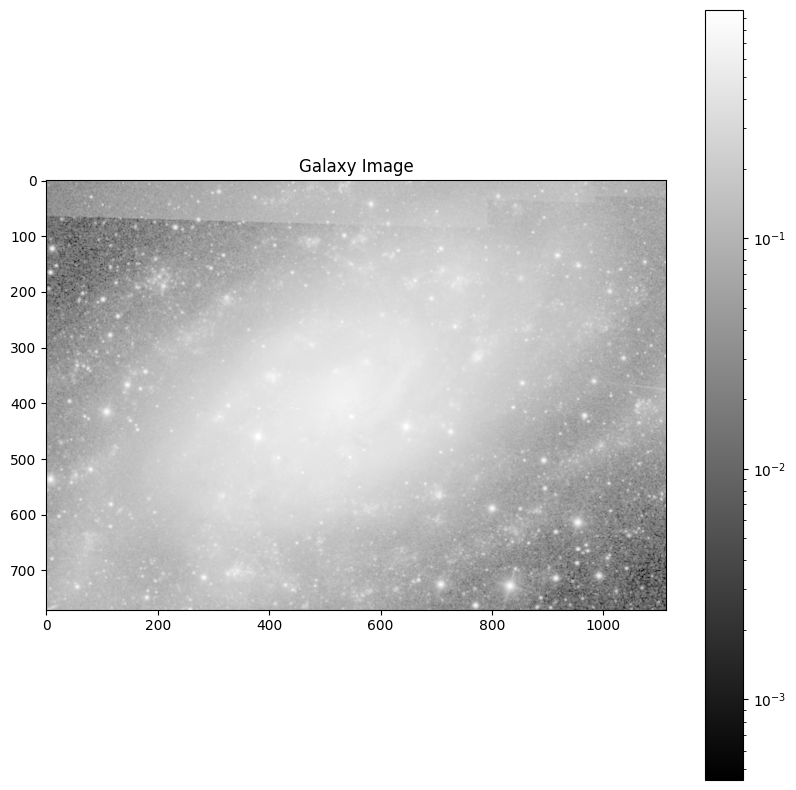

In [3]:
# Display the image using a logarithmic scale for better visualization
plt.figure(figsize=(10, 10))
plt.imshow(image_data, norm=LogNorm(), cmap='gray')
plt.colorbar()
plt.title('Galaxy Image')
plt.show()


Refined center coordinates: x=543.0373150936898, y=421.9223392422711


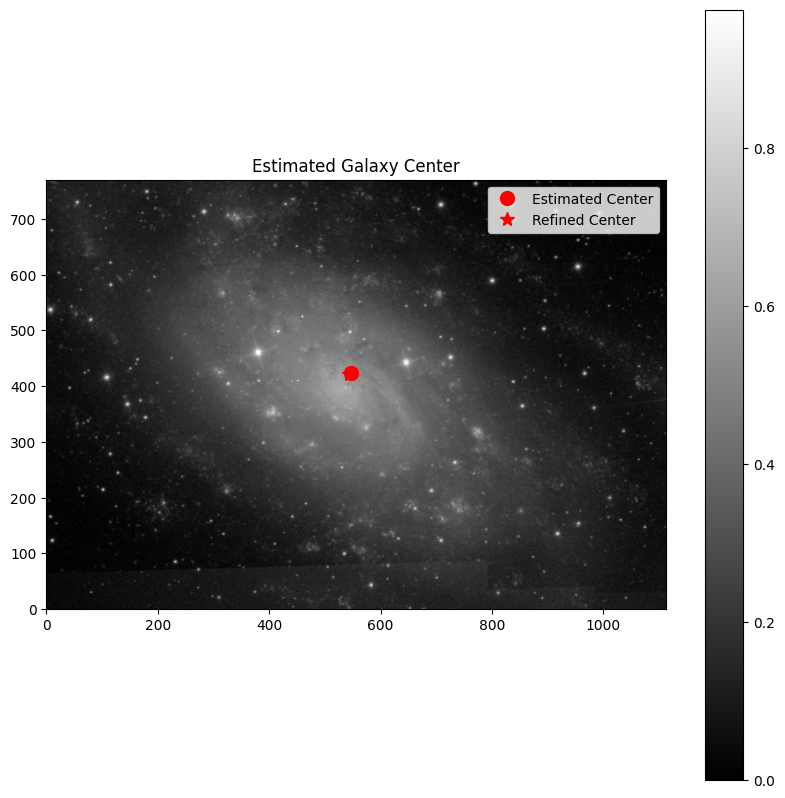

Estimated center coordinates: x=546, y=424


In [4]:
# Sum intensities along x and y axes
sum_x = np.sum(image_data, axis=0)
sum_y = np.sum(image_data, axis=1)

# Find the peak in the marginal sums
center_x = np.argmax(sum_x)
center_y = np.argmax(sum_y)

from photutils.centroids import centroid_com

# Define a small box around the approximate center to refine the centroid calculation
box_size = 50  # Adjust based on the image scale
x_min, x_max = max(0, center_x - box_size), min(image_data.shape[1], center_x + box_size)
y_min, y_max = max(0, center_y - box_size), min(image_data.shape[0], center_y + box_size)

sub_image = image_data[y_min:y_max, x_min:x_max]

# Calculate the centroid
centroid_y, centroid_x = centroid_com(sub_image)

# Adjust centroid relative to the full image
refined_center_x = x_min + centroid_x
refined_center_y = y_min + centroid_y


# Display the center location
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap='gray', origin='lower')
plt.plot(center_x, center_y, 'ro', markersize=10, label='Estimated Center')
plt.plot(refined_center_x, refined_center_y, 'r*', markersize=10, label='Refined Center')
print(f"Refined center coordinates: x={refined_center_x}, y={refined_center_y}")
plt.legend()
plt.colorbar()
plt.title('Estimated Galaxy Center')
plt.show()

print(f"Estimated center coordinates: x={center_x}, y={center_y}")


In [5]:
#image_data shape
print(image_data.shape)

(771, 1113)


In [6]:
import numpy as np
from photutils.isophote import Ellipse, EllipseGeometry

# Define the geometry starting at the refined center
geometry = EllipseGeometry(
    x0=refined_center_x, y0=refined_center_y, sma=200, eps=0.2, pa=np.deg2rad(135)
)  # sma is the semi-major axis

# Build an ellipse using the image data
ellipse = Ellipse(image_data, geometry)

# Fit the isophotes to the image data
isolist = ellipse.fit_image()


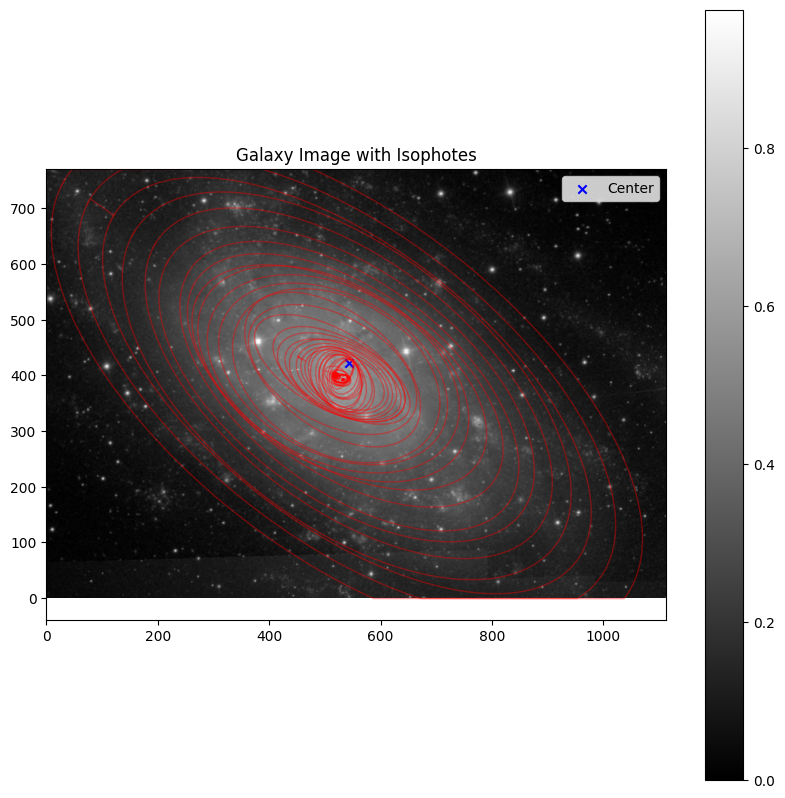

In [7]:
# Plot the image with fitted isophotes
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Galaxy Image with Isophotes')

# Overlay isophotes
incs = []
for j, iso in enumerate(isolist):
    if j!=0:
        a = iso.sma #semieje mayor
        b = iso.sma * (1 - iso.eps)
        incs.append(
            np.degrees(
                np.arccos(
                    b/a
                )
            )
        )

        
    x, y = iso.sampled_coordinates()
    plt.plot(x, y, color='red', lw=1.0, alpha=0.4)

plt.scatter(refined_center_x, refined_center_y, color='blue', marker='x', label='Center')
plt.legend()
plt.show()

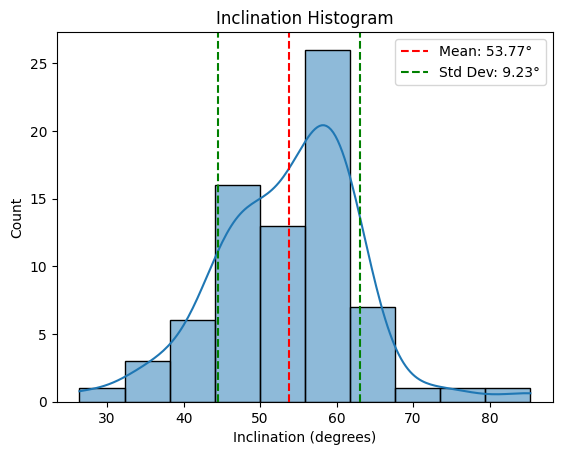

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

mean_inclination = np.mean(incs)
std_inclination = np.std(incs)

sns.histplot(incs, kde=True, bins=10)
plt.title('Inclination Histogram')
plt.xlabel('Inclination (degrees)')
plt.ylabel('Count')

plt.axvline(mean_inclination, color='r', linestyle='--', label=f'Mean: {mean_inclination:.2f}°')
plt.axvline(mean_inclination + std_inclination, color='g', linestyle='--', label=f'Std Dev: {std_inclination:.2f}°')
plt.axvline(mean_inclination - std_inclination, color='g', linestyle='--')

plt.legend()
plt.show()

In [9]:
# from photutils.isophote import build_ellipse_model
# # Create the isophote model
# iso_model = build_ellipse_model(image_data.shape, isolist)

# # Subtract the isophote model from the image
# residual_image = image_data - iso_model

# # Plot the residual image
# plt.figure(figsize=(10, 10))
# plt.imshow(residual_image, cmap='gray', origin='lower', vmin=-10, vmax=10)
# plt.colorbar()
# plt.title('Residual Image after Isophote Subtraction')
# plt.show()


/tmp/ipykernel_23282/323105699.py:16: RuntimeWarning: invalid value encountered in log10
  surface_brightness = -2.5 * np.log10(np.array(mean_intensity) - median)


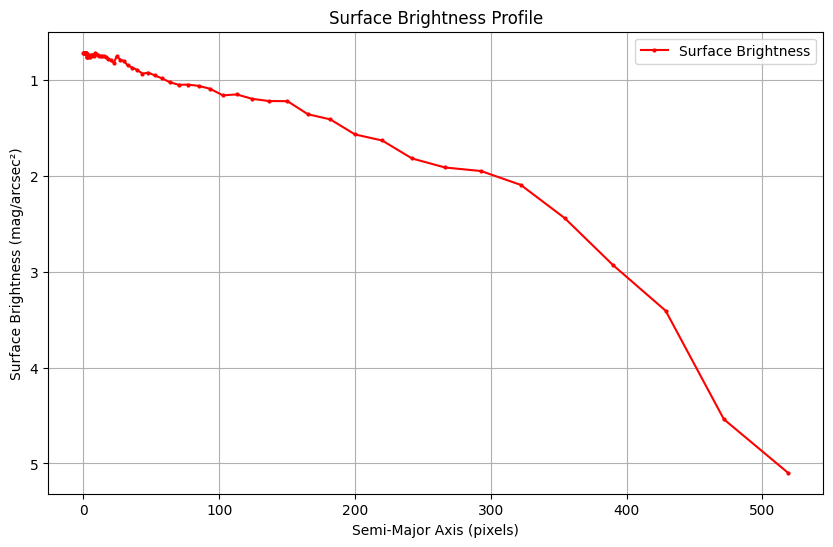

In [10]:
from astropy.stats import sigma_clipped_stats

# Calculate the background statistics
mean, median, stddev = sigma_clipped_stats(image_data)

# Extract radius (sma) and mean intensity from each isophote
radii = []
mean_intensity = []

for iso in isolist:
    radii.append(iso.sma)  # Semi-major axis of the isophote
    mean_intensity.append(iso.intens)

# Convert mean intensity to surface brightness in magnitude scale
# Using a simple conversion: mag = -2.5 * log10(intensity)
surface_brightness = -2.5 * np.log10(np.array(mean_intensity) - median)

# Plot the surface brightness profile
plt.figure(figsize=(10, 6))
plt.plot(radii, surface_brightness, '-o', color='red', label='Surface Brightness', markersize=2)
plt.gca().invert_yaxis()  # Magnitude decreases as brightness increases
plt.xlabel('Semi-Major Axis (pixels)')
plt.ylabel('Surface Brightness (mag/arcsec²)')
plt.title('Surface Brightness Profile')
plt.grid(True)
plt.legend()
plt.show()


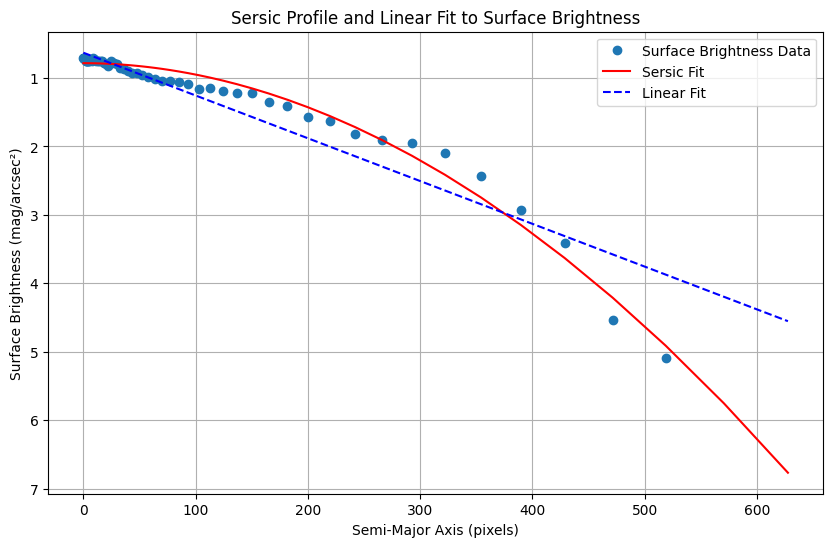

Fitted Sersic Parameters: mu_e=2.53 mag/arcsec², r_e=333.90 pixels, n=0.51
Fitted Linear Parameters: a=0.01, b=0.63


In [12]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Sersic profile in surface brightness
def sersic_surface_brightness(r, mu_e, r_e, n):
    b_n = 2 * n - 0.327
    return mu_e + 2.5 * b_n * ((r / r_e)**(1/n) - 1)

# Define a linear function
def linear_surface_brightness(r, a, b):
    return a * r + b

non_nan_radii = np.array(radii)[~np.isnan(surface_brightness)]
non_nan_surface_brightness = surface_brightness[~np.isnan(surface_brightness)]

# Fit the Sersic profile to the surface brightness data
popt_sersic, pcov_sersic = curve_fit(sersic_surface_brightness, non_nan_radii, non_nan_surface_brightness, p0=[20, 10, 2])
mu_e, r_e, n = popt_sersic

# Fit the linear function to the surface brightness data
popt_linear, pcov_linear = curve_fit(linear_surface_brightness, non_nan_radii, non_nan_surface_brightness)
a, b = popt_linear

# Plot the data, the fitted Sersic profile, and the linear fit
plt.figure(figsize=(10, 6))
plt.plot(radii, surface_brightness, 'o', label='Surface Brightness Data')
plt.plot(radii, sersic_surface_brightness(np.array(radii), *popt_sersic), '-', color='red', label='Sersic Fit')
plt.plot(radii, linear_surface_brightness(np.array(radii), *popt_linear), '--', color='blue', label='Linear Fit')
plt.gca().invert_yaxis()  # Magnitude scale, lower values mean brighter
plt.xlabel('Semi-Major Axis (pixels)')
plt.ylabel('Surface Brightness (mag/arcsec²)')
plt.title('Sersic Profile and Linear Fit to Surface Brightness')
plt.grid(True)
plt.legend()
plt.show()

print(f"Fitted Sersic Parameters: mu_e={mu_e:.2f} mag/arcsec², r_e={r_e:.2f} pixels, n={n:.2f}")
print(f"Fitted Linear Parameters: a={a:.2f}, b={b:.2f}")

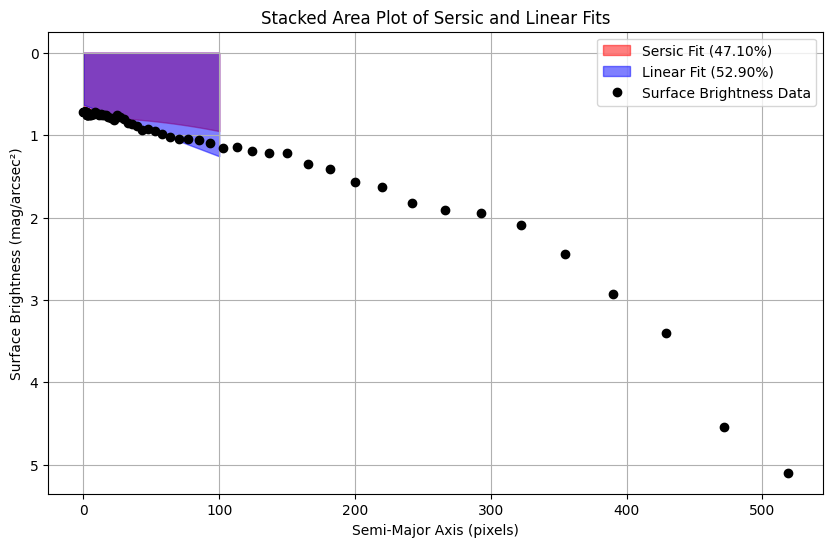

Área bajo la curva Sersic hasta x=100: 84.05
Área bajo la curva Lineal hasta x=100: 94.39
Porcentaje de área Sersic: 47.10%
Porcentaje de área Lineal: 52.90%


In [14]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Definir el perfil de Sersic en brillo superficial
def sersic_surface_brightness(r, mu_e, r_e, n):
    b_n = 2 * n - 0.327
    return mu_e + 2.5 * b_n * ((r / r_e)**(1/n) - 1)

# Definir una función lineal
def linear_surface_brightness(r, a, b):
    return a * r + b

# Filtrar datos no nulos
non_nan_radii = np.array(radii)[~np.isnan(surface_brightness)]
non_nan_surface_brightness = surface_brightness[~np.isnan(surface_brightness)]

# Ajustar el perfil de Sersic a los datos de brillo superficial
popt_sersic, pcov_sersic = curve_fit(sersic_surface_brightness, non_nan_radii, non_nan_surface_brightness, p0=[20, 10, 2])
mu_e, r_e, n = popt_sersic

# Ajustar la función lineal a los datos de brillo superficial
popt_linear, pcov_linear = curve_fit(linear_surface_brightness, non_nan_radii, non_nan_surface_brightness)
a, b = popt_linear

# Calcular el área bajo la curva para ambas funciones hasta x = 100
r_max = 100
r_values = np.linspace(0, r_max, 500)
sersic_area = np.trapezoid(sersic_surface_brightness(r_values, *popt_sersic), r_values)
linear_area = np.trapezoid(linear_surface_brightness(r_values, *popt_linear), r_values)
total_area = sersic_area + linear_area

# Calcular el porcentaje de área para cada curva
sersic_percentage = (sersic_area / total_area) * 100
linear_percentage = (linear_area / total_area) * 100

# Gráfica de áreas apiladas
plt.figure(figsize=(10, 6))
plt.fill_between(r_values, sersic_surface_brightness(r_values, *popt_sersic), color='red', alpha=0.5, label=f'Sersic Fit ({sersic_percentage:.2f}%)')
plt.fill_between(r_values, linear_surface_brightness(r_values, *popt_linear), color='blue', alpha=0.5, label=f'Linear Fit ({linear_percentage:.2f}%)')
plt.plot(radii, surface_brightness, 'o', label='Surface Brightness Data', color='black')
plt.gca().invert_yaxis()  # Escala de magnitudes, valores más bajos son más brillantes
plt.xlabel('Semi-Major Axis (pixels)')
plt.ylabel('Surface Brightness (mag/arcsec²)')
plt.title('Stacked Area Plot of Sersic and Linear Fits')
plt.grid(True)
plt.legend()
plt.show()

print(f"Área bajo la curva Sersic hasta x={r_max}: {sersic_area:.2f}")
print(f"Área bajo la curva Lineal hasta x={r_max}: {linear_area:.2f}")
print(f"Porcentaje de área Sersic: {sersic_percentage:.2f}%")
print(f"Porcentaje de área Lineal: {linear_percentage:.2f}%")


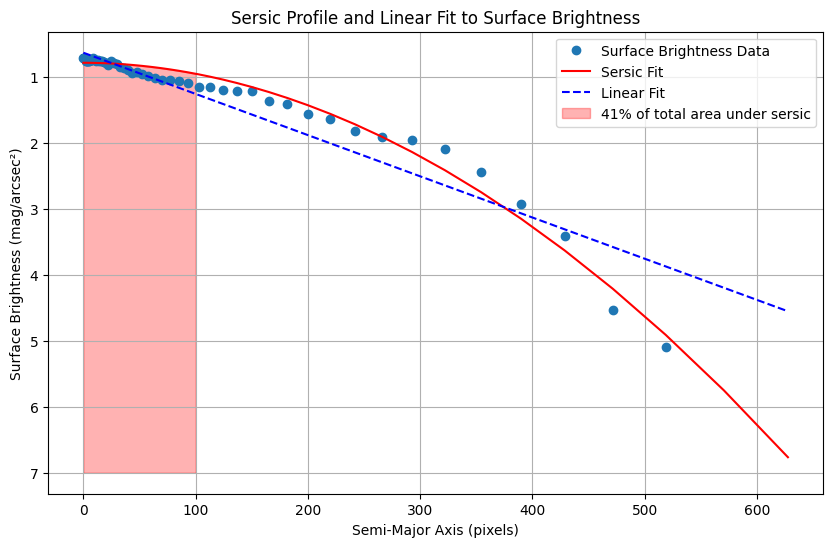

Fitted Sersic Parameters: mu_e=2.53 mag/arcsec², r_e=333.90 pixels, n=0.51
Fitted Linear Parameters: a=0.01, b=0.63
Area under Sersic (0-100): 46.16
Total area under Sersic: 111.96
Percentage of area (0-100): 41.23%


In [22]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Define the Sersic profile in surface brightness
def sersic_surface_brightness(r, mu_e, r_e, n):
    b_n = 2 * n - 0.327
    return mu_e + 2.5 * b_n * ((r / r_e)**(1/n) - 1)

# Define a linear function
def linear_surface_brightness(r, a, b):
    return a * r + b

# Remove NaNs from the data
non_nan_radii = np.array(radii)[~np.isnan(surface_brightness)]
non_nan_surface_brightness = surface_brightness[~np.isnan(surface_brightness)]

# Fit the Sersic profile to the surface brightness data
popt_sersic, pcov_sersic = curve_fit(sersic_surface_brightness, non_nan_radii, non_nan_surface_brightness, p0=[20, 10, 2])
mu_e, r_e, n = popt_sersic

# Fit the linear function to the surface brightness data
popt_linear, pcov_linear = curve_fit(linear_surface_brightness, non_nan_radii, non_nan_surface_brightness)
a, b = popt_linear

# Define the Sersic profile function for integration
def sersic_intensity(r):
    return 10 ** (-0.4 * sersic_surface_brightness(r, mu_e, r_e, n))

# Calculate the total area under the Sersic curve from 0 to max radius
total_area, _ = quad(sersic_intensity, 0, max(non_nan_radii))

# Calculate the area under the Sersic curve from 0 to 100
area_0_100, _ = quad(sersic_intensity, 0, 100)

# Calculate the percentage of area between x = 0 and x = 100
percentage_area_0_100 = (area_0_100 / total_area) * 100

# Plot the data, the fitted Sersic profile, and the linear fit
plt.figure(figsize=(10, 6))
plt.plot(radii, surface_brightness, 'o', label='Surface Brightness Data')
plt.plot(radii, sersic_surface_brightness(np.array(radii), *popt_sersic), '-', color='red', label='Sersic Fit')
plt.plot(radii, linear_surface_brightness(np.array(radii), *popt_linear), '--', color='blue', label='Linear Fit')

# Fill the area under the Sersic curve from x=0 to x=100
r_vals = np.linspace(0, 100, 500)
plt.fill_between(x=r_vals, y1= [7]*len(r_vals), y2=sersic_surface_brightness(r_vals, mu_e, r_e, n), color='red', alpha=0.3, label='41% of total area under sersic')

plt.gca().invert_yaxis()  # Magnitude scale, lower values mean brighter
plt.xlabel('Semi-Major Axis (pixels)')
plt.ylabel('Surface Brightness (mag/arcsec²)')
plt.title('Sersic Profile and Linear Fit to Surface Brightness')
plt.grid(True)
plt.legend()
plt.show()

print(f"Fitted Sersic Parameters: mu_e={mu_e:.2f} mag/arcsec², r_e={r_e:.2f} pixels, n={n:.2f}")
print(f"Fitted Linear Parameters: a={a:.2f}, b={b:.2f}")
print(f"Area under Sersic (0-100): {area_0_100:.2f}")
print(f"Total area under Sersic: {total_area:.2f}")
print(f"Percentage of area (0-100): {percentage_area_0_100:.2f}%")


## Pitch angle

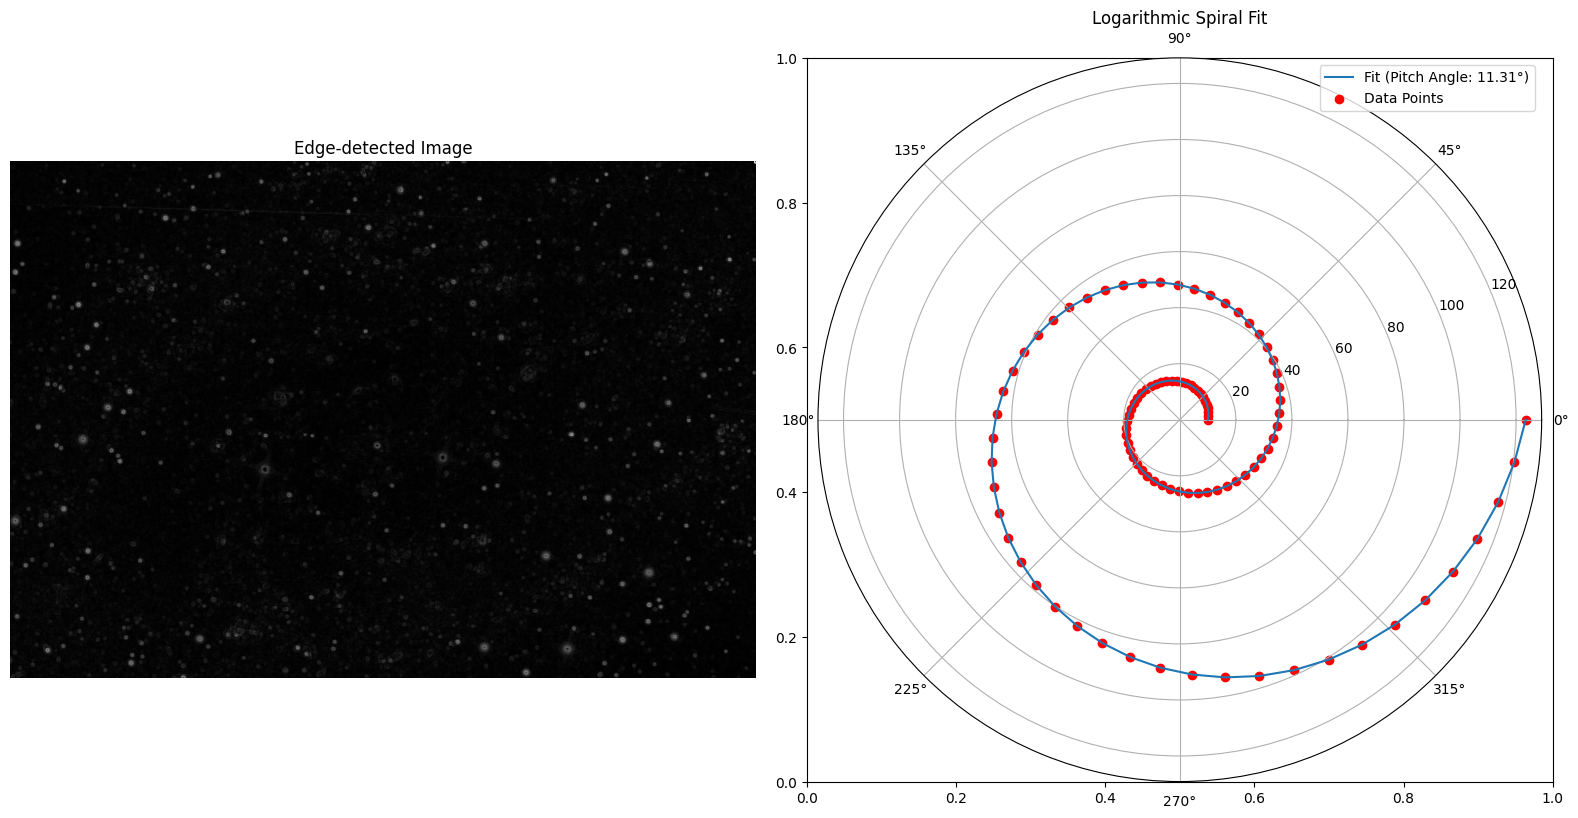

Estimated Pitch Angle: 11.31°


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io, filters
import cv2

# Load and display the image
image_path = '../data/images/cut_ngc2403.png'
image = io.imread(image_path)

image_path = '../data/images/ngc2403.png'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert to grayscale
image_data = np.dot(plt.imread(image_path)[..., :3], [0.2989, 0.5870, 0.1140])

# Enhance the edges to highlight the spiral arms
edges = filters.sobel(gray_image)

# Define the logarithmic spiral function
def log_spiral(theta, a, b):
    return a * np.exp(b * theta)

# Example coordinates of a spiral arm (to be replaced by actual coordinates)
# You should trace or select points on the spiral arm manually.
# For demonstration, let's assume manually selected coordinates:
theta = np.linspace(0, 4 * np.pi, 100)  # Angular positions (in radians)
r = log_spiral(theta, 10, 0.2)  # Radial distances for demo

# Fit the logarithmic spiral model
params, _ = curve_fit(log_spiral, theta, r)
a_fit, b_fit = params

# Calculate the pitch angle
pitch_angle = np.degrees(np.arctan(b_fit))

# Plot the spiral fit
theta_fit = np.linspace(0, 4 * np.pi, 100)
r_fit = log_spiral(theta_fit, *params)

import matplotlib.pyplot as plt

# Assuming theta_fit, r_fit, theta, r, pitch_angle, and edges are already defined

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the logarithmic spiral fit on the first subplot
axes[0] = plt.subplot(122, projection='polar')
axes[0].plot(theta_fit, r_fit, label=f'Fit (Pitch Angle: {pitch_angle:.2f}°)')
axes[0].scatter(theta, r, color='red', label='Data Points')
axes[0].set_title("Logarithmic Spiral Fit")
axes[0].legend()

# Display the edge-detected image on the second subplot
axes[1] = plt.subplot(121)
axes[1].imshow(edges, cmap='gray')
axes[1].set_title("Edge-detected Image")
axes[1].axis('off')  # Hide the axis for the image

plt.tight_layout()
plt.show()

print(f"Estimated Pitch Angle: {pitch_angle:.2f}°")
